In [43]:
"""
Citi Group Stock Analysis and Machine Learning Prediction
------------------------------------------------------------
This Python Notebook performs comprehensive financial analysis and Machine Learning
based prediction on Citi Group (C) stock data

Libraries used:
pip install yfinance pandas numpy matlpotlib seaborn scikit-learn ta
"""

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# For Technical Analysis
!pip install ta # If using ipynb or colab
import ta

# For Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [44]:
# ==================================
# STEP 1: DATA COLLECTION
# ==================================

def fetch_stock_data(ticker = "C", period = "5y"):
  """
  Here we will be downloading the historical stock data from Yahoo Finance

  Parameters:
  - ticker: Stock symbol (default: C for Citi Group)
  - period: Time period (1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, ytd, max)
  """
  print(f"Fetching {ticker} stock data for {period}...")
  stock = yf.Ticker(ticker)
  df = stock.history(period=period)

  # Displaying basic information

  print(f"\nData Shape: {df.shape}")
  print(f"Date Range: {df.index[0]} to {df.index[-1]}")
  print(f"\nFirst few rows: \n{df.head()}")
  print(f"\nLast few rows: \n{df.tail()}")

  return df
#citi_dataframe = fetch_stock_data()



In [45]:
# =======================================
# STEP 2: EXPLORATORY DATA ANALYSIS (EDA)
# =======================================

def perform_eda(df):
  """
  In this step we will be performing exploratory data analysis on the stock data
  """
  print("\n" + "="*60)
  print("EXPLORATORY DATA ANALYSIS")
  print("="*60)

  # Basic statistics
  print("\nBasic Statistics:")
  print(df.describe())

  # Checking for missing values

  print(f"\nMissing Value:\n{df.isnull().sum()}")

  # Data types
  print(f"\nData Types:\n{df.dtypes}")

  return df
# The output of fetch_stock_data becomes the input for perform_eda
#stock_df = perform_eda(fetch_stock_data("C"))

In [46]:
# ==============================================
# Step 3: FINANCIAL ANALYSIS
# ===============================================

def financial_analysis(df):
  """

  We will be analysing historical trends, volatility and trading volume
  """

  print("\n" + "="*60)
  print("FINANCIAL ANALYSIS")
  print("="*60)

  # 1. Price Trends - Moving Averages
  df['SMA_20'] = df['Close'].rolling(window=20).mean() # 20 day Simple Moving Average
  df['SMA_50'] = df['Close'].rolling(window=50).mean()
  df['SMA_100'] = df['Close'].rolling(window=100).mean()
  df['EMA_20'] = df['Close'].ewm(span=20, adjust=False).mean() # Exponential Moving Average

  # 2. Returns Analysis

  df['Daily_Return'] = df['Close'].pct_change() # Daily percentage change
  df['Cumulative_Return'] = (1 + df['Daily_Return']).cumprod() - 1 # Cumulative Return

  # 3. Volatility Analysis

  df['Volatility_30'] = df['Daily_Return'].rolling(window=30).std() * np.sqrt(252)

  # Bollinger Bands (volatility indicator)
  df['BB_Middle'] = df['Close'].rolling(window=20).mean()
  df['BB_Upper'] = df['BB_Middle'] + 2 * df['Close'].rolling(window=20).std()
  df['BB_Lower'] = df['BB_Middle'] - 2 * df['Close'].rolling(window=20).std()

  # 4. VOLUME ANALYSIS
  df['Volume_SMA_20'] = df['Volume'].rolling(window=20).mean()
  df['Volume_Ratio'] = df['Volume'] / df['Volume_SMA_20']  # Volume relative to average

  # 5. TECHNICAL INDICATORS
  # RSI (Relative Strength Index) - momentum indicator
  df['RSI'] = ta.momentum.RSIIndicator(df['Close'], window=14).rsi()

  # MACD (Moving Average Convergence Divergence)
  macd = ta.trend.MACD(df['Close'])
  df['MACD'] = macd.macd()
  df['MACD_Signal'] = macd.macd_signal()
  df['MACD_Diff'] = macd.macd_diff()

  # Print key metrics
  print(f"\nKey Financial Metrics:")
  print(f"Total Return: {df['Cumulative_Return'].iloc[-1]:.2%}")
  print(f"Average Daily Return: {df['Daily_Return'].mean():.4%}")
  print(f"Daily Volatility: {df['Daily_Return'].std():.4%}")
  print(f"Annualized Volatility: {df['Daily_Return'].std() * np.sqrt(252):.2%}")
  print(f"Sharpe Ratio (assuming 0% risk-free rate): {(df['Daily_Return'].mean() / df['Daily_Return'].std()) * np.sqrt(252):.2f}")
  print(f"Max Drawdown: {((df['Close'] / df['Close'].cummax()) - 1).min():.2%}")

  return df

In [47]:
# ============================================================================
# PART 4: FEATURE ENGINEERING FOR MACHINE LEARNING
# ============================================================================

def create_ml_features(df):
    """
    Create features for machine learning models
    """
    print("\n" + "="*60)
    print("FEATURE ENGINEERING")
    print("="*60)

    # Create lagged features (previous days' prices)
    for i in [1, 2, 3, 5, 10]:
        df[f'Close_Lag_{i}'] = df['Close'].shift(i)

    # Rolling statistics
    df['Close_Rolling_Mean_5'] = df['Close'].rolling(window=5).mean()
    df['Close_Rolling_Std_5'] = df['Close'].rolling(window=5).std()
    df['Close_Rolling_Mean_20'] = df['Close'].rolling(window=20).mean()

    # Price momentum
    df['Momentum_5'] = df['Close'] - df['Close'].shift(5)
    df['Momentum_10'] = df['Close'] - df['Close'].shift(10)

    # Target variable: Next day's closing price
    df['Target'] = df['Close'].shift(-1)

    # Remove rows with NaN values
    df_clean = df.dropna()

    print(f"\nFeatures created: {df_clean.shape[1]} columns")
    print(f"Clean dataset shape: {df_clean.shape}")

    return df_clean

In [48]:
# ============================================================================
# PART 5: MACHINE LEARNING MODELS
# ============================================================================

def prepare_ml_data(df):
    """
    Prepare data for machine learning
    """
    # Select features for ML
    feature_columns = [
        'Open', 'High', 'Low', 'Close', 'Volume',
        'SMA_20', 'SMA_50', 'SMA_100', 'EMA_20', 'RSI', 'MACD',
        'Close_Lag_1', 'Close_Lag_2', 'Close_Lag_3', 'Close_Lag_5', 'Close_Lag_10',
        'Close_Rolling_Mean_5', 'Close_Rolling_Std_5',
        'Momentum_5', 'Momentum_10', 'Volatility_30'
    ]

    X = df[feature_columns]
    y = df['Target']

    # Split data: 80% training, 20% testing (chronological split)
    split_idx = int(len(X) * 0.8)
    X_train, X_test = X[:split_idx], X[split_idx:]
    y_train, y_test = y[:split_idx], y[split_idx:]

    # Scale features (important for ML models)
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    print(f"\nTraining set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler, X_test.index

def train_models(X_train, X_test, y_train, y_test):
    """
    Train multiple ML models and compare performance
    """
    print("\n" + "="*60)
    print("MACHINE LEARNING MODELS")
    print("="*60)

    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
    }

    results = {}

    for name, model in models.items():
        print(f"\n--- {name} ---")

        # Train model
        model.fit(X_train, y_train)

        # Predictions
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)

        # Evaluation metrics
        train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
        test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
        train_mae = mean_absolute_error(y_train, y_pred_train)
        test_mae = mean_absolute_error(y_test, y_pred_test)
        train_r2 = r2_score(y_train, y_pred_train)
        test_r2 = r2_score(y_test, y_pred_test)

        print(f"Train RMSE: ${train_rmse:.2f}")
        print(f"Test RMSE: ${test_rmse:.2f}")
        print(f"Train MAE: ${train_mae:.2f}")
        print(f"Test MAE: ${test_mae:.2f}")
        print(f"Train R²: {train_r2:.4f}")
        print(f"Test R²: {test_r2:.4f}")

        results[name] = {
            'model': model,
            'predictions': y_pred_test,
            'rmse': test_rmse,
            'mae': test_mae,
            'r2': test_r2
        }

    return results


In [49]:
# ============================================================================
# PART 6: VISUALIZATION
# ============================================================================

def visualize_results(df, results, test_dates, y_test):
    """
    Create comprehensive visualizations
    """
    print("\n" + "="*60)
    print("CREATING VISUALIZATIONS")
    print("="*60)

    fig = plt.figure(figsize=(20, 12))

    # 1. Price Trends with Moving Averages
    ax1 = plt.subplot(3, 3, 1)
    ax1.plot(df.index, df['Close'], label='Close Price', alpha=0.7)
    ax1.plot(df.index, df['SMA_20'], label='SMA 20', alpha=0.7)
    ax1.plot(df.index, df['SMA_50'], label='SMA 50', alpha=0.7)
    ax1.plot(df.index, df['SMA_100'], label='SMA 100', alpha=0.7)
    ax1.set_title('Price Trends with Moving Averages')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price ($)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. Bollinger Bands
    ax2 = plt.subplot(3, 3, 2)
    ax2.plot(df.index, df['Close'], label='Close Price')
    ax2.plot(df.index, df['BB_Upper'], label='Upper Band', linestyle='--', alpha=0.7)
    ax2.plot(df.index, df['BB_Lower'], label='Lower Band', linestyle='--', alpha=0.7)
    ax2.fill_between(df.index, df['BB_Lower'], df['BB_Upper'], alpha=0.2)
    ax2.set_title('Bollinger Bands (Volatility)')
    ax2.set_xlabel('Date')
    ax2.set_ylabel('Price ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Volume Analysis
    ax3 = plt.subplot(3, 3, 3)
    ax3.bar(df.index, df['Volume'], alpha=0.5)
    ax3.plot(df.index, df['Volume_SMA_20'], color='red', label='Volume SMA 20')
    ax3.set_title('Trading Volume Analysis')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Volume')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Daily Returns Distribution
    ax4 = plt.subplot(3, 3, 4)
    ax4.hist(df['Daily_Return'].dropna(), bins=50, edgecolor='black', alpha=0.7)
    ax4.axvline(df['Daily_Return'].mean(), color='red', linestyle='--', label=f'Mean: {df["Daily_Return"].mean():.4f}')
    ax4.set_title('Daily Returns Distribution')
    ax4.set_xlabel('Daily Return')
    ax4.set_ylabel('Frequency')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    # 5. Cumulative Returns
    ax5 = plt.subplot(3, 3, 5)
    ax5.plot(df.index, df['Cumulative_Return'] * 100)
    ax5.set_title('Cumulative Returns')
    ax5.set_xlabel('Date')
    ax5.set_ylabel('Return (%)')
    ax5.grid(True, alpha=0.3)

    # 6. RSI Indicator
    ax6 = plt.subplot(3, 3, 6)
    ax6.plot(df.index, df['RSI'])
    ax6.axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
    ax6.axhline(30, color='green', linestyle='--', alpha=0.5, label='Oversold (30)')
    ax6.set_title('RSI (Relative Strength Index)')
    ax6.set_xlabel('Date')
    ax6.set_ylabel('RSI')
    ax6.legend()
    ax6.grid(True, alpha=0.3)

    # 7. MACD
    ax7 = plt.subplot(3, 3, 7)
    ax7.plot(df.index, df['MACD'], label='MACD')
    ax7.plot(df.index, df['MACD_Signal'], label='Signal Line')
    ax7.bar(df.index, df['MACD_Diff'], label='MACD Diff', alpha=0.3)
    ax7.set_title('MACD Indicator')
    ax7.set_xlabel('Date')
    ax7.legend()
    ax7.grid(True, alpha=0.3)

    # 8. ML Predictions Comparison
    ax8 = plt.subplot(3, 3, 8)
    ax8.plot(test_dates, y_test.values, label='Actual Price', marker='o', markersize=2)
    for name, result in results.items():
        ax8.plot(test_dates, result['predictions'], label=f'{name} (R²={result["r2"]:.3f})', alpha=0.7)
    ax8.set_title('ML Model Predictions vs Actual')
    ax8.set_xlabel('Date')
    ax8.set_ylabel('Price ($)')
    ax8.legend()
    ax8.grid(True, alpha=0.3)

    # 9. Prediction Error Distribution
    ax9 = plt.subplot(3, 3, 9)
    for name, result in results.items():
        errors = y_test.values - result['predictions']
        ax9.hist(errors, bins=30, alpha=0.5, label=f'{name} (MAE=${result["mae"]:.2f})')
    ax9.set_title('Prediction Error Distribution')
    ax9.set_xlabel('Prediction Error ($)')
    ax9.set_ylabel('Frequency')
    ax9.legend()
    ax9.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('c_complete_analysis.png', dpi=300, bbox_inches='tight')
    print("\nVisualization saved as 'c_complete_analysis.png'")
    plt.show()

Fetching C stock data for 5y...

Data Shape: (1256, 7)
Date Range: 2020-10-05 00:00:00-04:00 to 2025-10-03 00:00:00-04:00

First few rows: 
                                Open       High        Low      Close  \
Date                                                                    
2020-10-05 00:00:00-04:00  36.786991  37.593214  36.745434  37.327244   
2020-10-06 00:00:00-04:00  37.801004  38.283077  36.703878  36.911667   
2020-10-07 00:00:00-04:00  37.418674  37.925680  37.077900  37.269066   
2020-10-08 00:00:00-04:00  37.327230  37.543329  36.803601  37.169312   
2020-10-09 00:00:00-04:00  37.410355  37.892428  37.144385  37.343864   

                             Volume  Dividends  Stock Splits  
Date                                                          
2020-10-05 00:00:00-04:00  24170600        0.0           0.0  
2020-10-06 00:00:00-04:00  29505900        0.0           0.0  
2020-10-07 00:00:00-04:00  22135800        0.0           0.0  
2020-10-08 00:00:00-04:00  286307

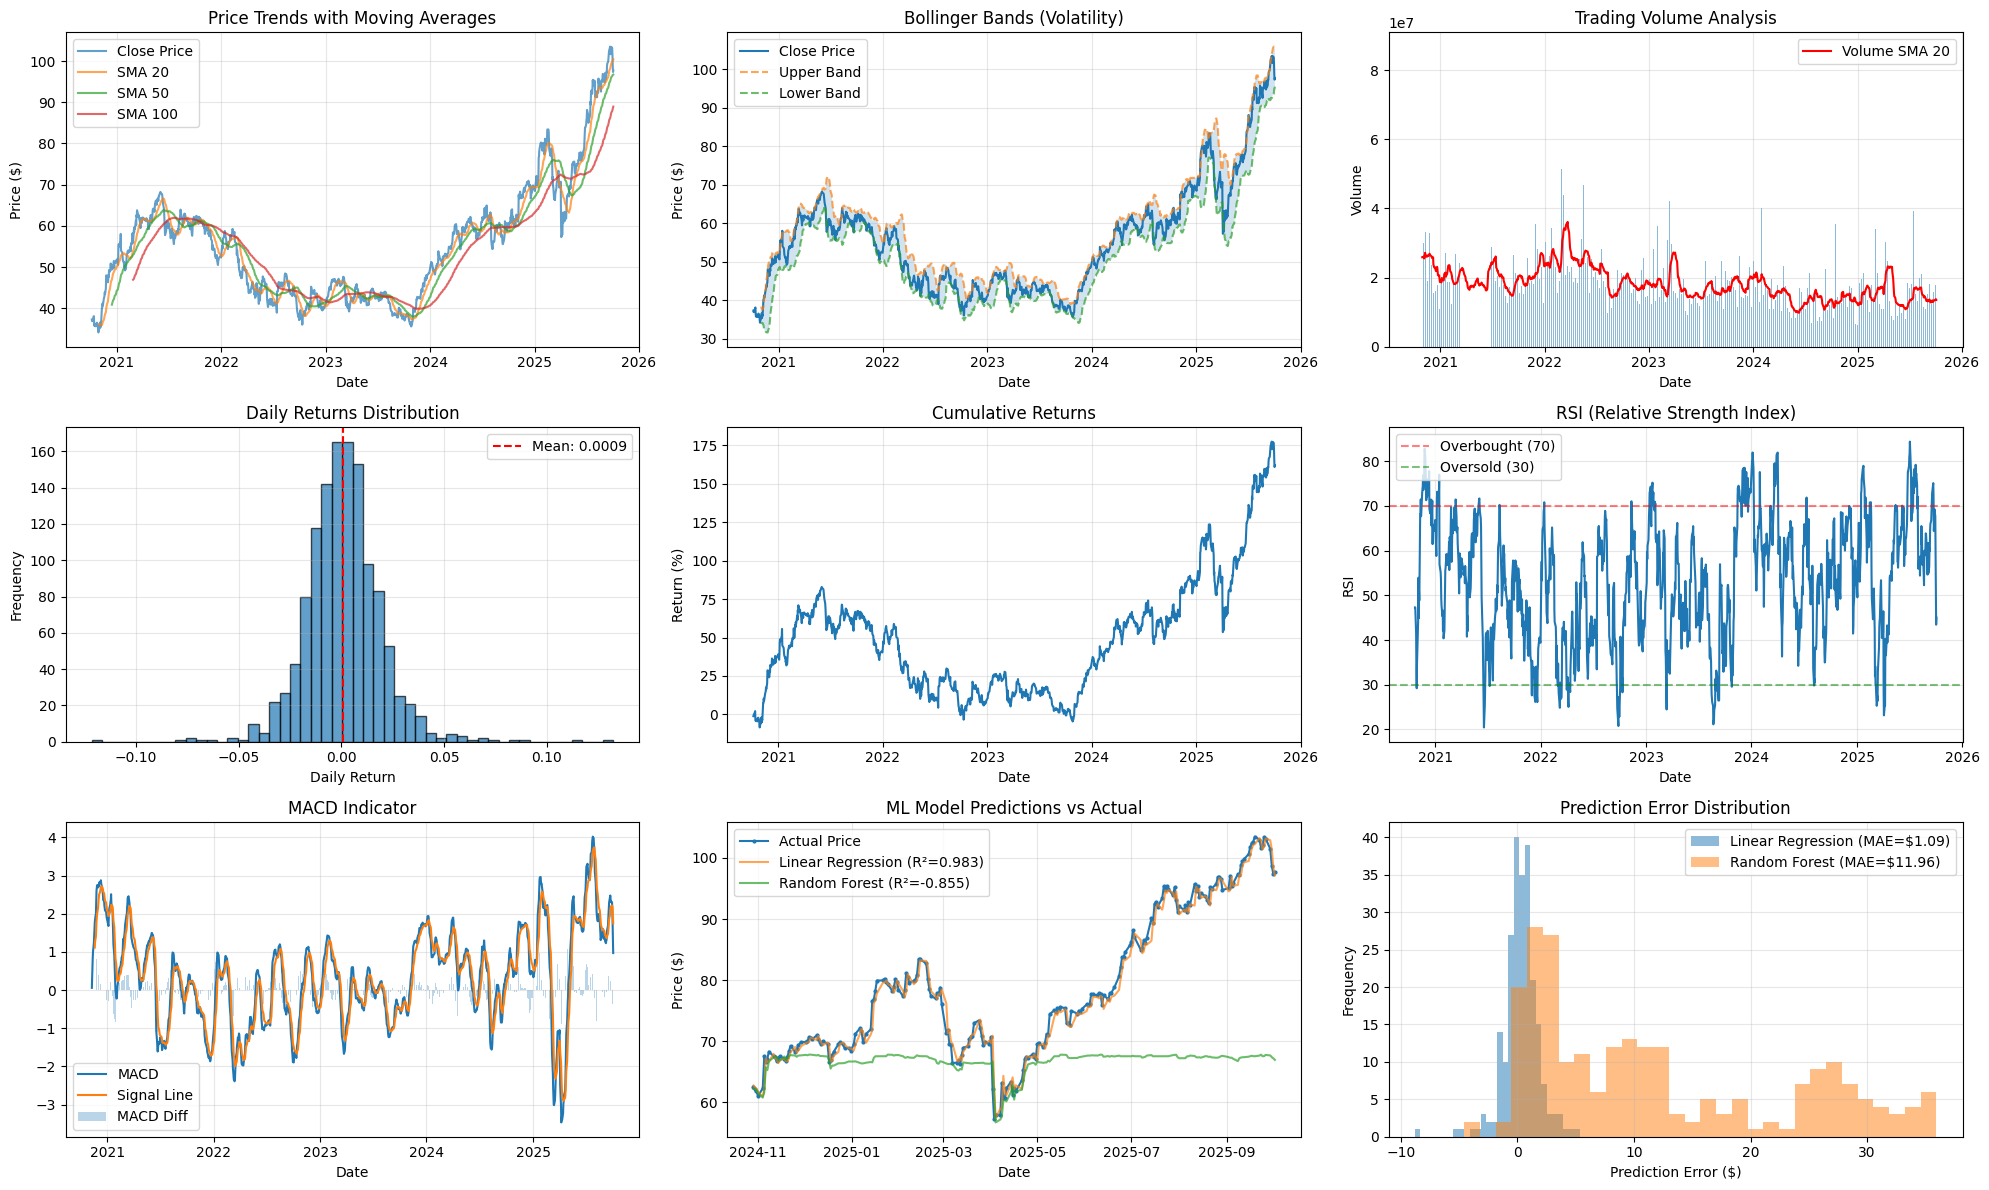


ANALYSIS COMPLETE!

Key Takeaways:
1. Financial metrics show overall trend and risk profile
2. Technical indicators help identify trading signals
3. ML models can predict prices but should be used cautiously
4. Always validate predictions with actual market conditions


In [50]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

if __name__ == "__main__":
    # Step 1: Fetch data
    df = fetch_stock_data("C", period="5y")

    # Step 2: EDA
    df = perform_eda(df)

    # Step 3: Financial Analysis
    df = financial_analysis(df)

    # Step 4: Feature Engineering
    df_ml = create_ml_features(df)

    # Step 5: Prepare ML data
    X_train, X_test, y_train, y_test, scaler, test_dates = prepare_ml_data(df_ml)

    # Step 6: Train models
    results = train_models(X_train, X_test, y_train, y_test)

    # Step 7: Visualize
    visualize_results(df, results, test_dates, y_test)

    print("\n" + "="*60)
    print("ANALYSIS COMPLETE!")
    print("="*60)
    print("\nKey Takeaways:")
    print("1. Financial metrics show overall trend and risk profile")
    print("2. Technical indicators help identify trading signals")
    print("3. ML models can predict prices but should be used cautiously")
    print("4. Always validate predictions with actual market conditions")
  #  print("\nNext Steps:")